# Milestone 2 Initial Analysis

## Title: It’s a beer’s, beer’s, beer’s world

## Abstract:
What if we re-arranged the world through beer taste? What would be the map resulting from it? What countries will be linked per their beer’s love? Can natural enemies become friends over a nice cold beverage? 

This project will have two phases: the first will be to find the best method to compute the favorite beer style per country, and the second to reassemble them according to the latter results.

For the first one, we will analyze several ways to find, and try to be as accurate as possible with the dataset given:  we plan to try various methods and libraries to generate the results, and compare the resultings insights we find, and hopefully tell an awesome, easy-to-follow story using a combination of maps and statistics.

Then, we will use those various methods to cluster the different countries, and observe the new world beer map!

## Research Questions:
1. What is the best method to find the favorite beer per country?
2. What happens if we draw the world’s boundaries using beer preferences?

The following details some of the initial analysis we completed while exploring possible research questions and the feasibility of our ideas.

## 0 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DATA = './data/'
BEER = 'RateBeer/'

## 1 Open data files
### 1.1 Open users.csv
#### Problem:
The 2 dataset (beer advocate and ratebeer) have really different repartition of users’s locations.
#### Solution:
We will use only one dataset, the one that have the better repartition. Indeed, fusing the 2 could be dangerous, as we do not know if the “common users” contain really all the common users of the 2 websites

In [2]:
users = pd.read_csv(DATA + BEER + 'users.csv',  sep=',')
tot_users = len(users)
print("Number of users : {}.".format(tot_users))
users.head(1)

Number of users : 70174.


,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland


The number of reviews is like a power law with some outliners!

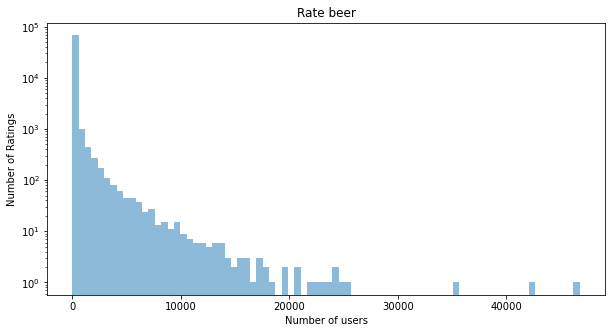

In [3]:
fig = plt.subplots(figsize= (10,5))

plt.hist(users.nbr_ratings.values, bins = 80,log = True, alpha = 0.5)
plt.title('Rate beer')
plt.xlabel("Number of users")
plt.ylabel("Number of Ratings", rotation = 90)
plt.show()

### 1.2 Open ratings.txt
The dataset is too large to do a quick analysis. We therefore import the first 300,000 ratings.

In [4]:
DF_PATH = DATA + BEER + 'ratings.txt'
data = {}
max_rows = 300000
with open(DF_PATH,'r', encoding='utf-8') as file:
    count = 1
    for word in file:
        if word !='\n':
            lst = word.strip('\n').split(': ')
            if lst[0] in data:
                data[lst[0]].append(lst[1])
            else:
                data[lst[0]] = [lst[1]]
            if count >=max_rows*16:
                break
            count+=1
ratings = pd.DataFrame(data)
print('There are {} rows.'.format(len(ratings)))
ratings.head(1)

There are 300000 rows.


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.00,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."


### 1.3 Open continent_and_region.csv
We import an additional dataset to be able to make an analysis by sub-region. In the initial dataset we have only the country of the user.

In [5]:
geography = pd.read_csv(DATA + 'continent_and_region.csv',  sep=',')
geography.head(1)

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4.0,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN


## 2 Filtering data

#### Problem:
Some countries have way more users providing reviews/ratings, and some have very few. This means that we can be extremely confident about some countries, but for those with sparse data, making conclusions about their preferences from smaller samples may be inaccurate. The same argument could be made about deciding whether to trust users who write few reviews, or to make conclusions about beers for which few reviews are written.
#### Solution:
We plan to monitor the sparsity of the data and implement thresholds when needed, to ensure that we’re making our conclusions from reasonably-sized samples. Moreover, a larger analyze could be made about sub-region to be able to have more proper result


### 2.1 Users without location

In [6]:
users = users.dropna(subset=['location'])
print("Number of users after filtering: {}. \nIt's {:.2f}% of the initial number of users ."
      .format(len(users),len(users)/tot_users*100))

Number of users after filtering: 50592. 
It's 72.10% of the initial number of users .


### 2.2 Users with less than 10 ratings

In [7]:
users_threshold = 10
users = users[users["nbr_ratings"]>=users_threshold]
print("Number of users after filtering: {}. \nIt's {:.2f}% of the initial number of users ."
      .format(len(users),len(users)/tot_users*100))

Number of users after filtering: 15232. 
It's 21.71% of the initial number of users .


Now let's see the country repartition of the users

In [8]:
users_group = users.groupby("location")
tot_location = len(users_group)
print("Number of different locations: {}.".format(tot_location))
users_group.agg('size').sort_values(ascending = False).head(3)

Number of different locations: 157.


location
Canada                       992
United States, California    816
Poland                       777
dtype: int64

### 2.3 New column country/ state/ region/ sub-region

With the help of the dataset from  https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv, we add the region and continent.

NOTE : United Kingdowm is divided in 4 : Scotland, Norhtern Ireland, Wales and England

In [9]:
geography = geography.drop(['alpha-2','alpha-3','country-code','iso_3166-2','intermediate-region','region-code','sub-region-code','intermediate-region-code'], axis=1)
geography.rename(columns = {'name':'country'}, inplace = True)
geography.head(1)

,country,region,sub-region
0,Afghanistan,Asia,Southern Asia


In [10]:
users['country'] = users.apply(lambda x : x.location.split(',')[0], axis = 1)
users['state'] = users.apply(lambda x : x.location.split(',')[1] if len(x.location.split(','))== 2 else None, axis = 1)
users = pd.merge(users, geography, left_on='country', right_on='country')

users = users.drop(['location'], axis=1)
users.head(1)

,nbr_ratings,user_id,user_name,joined,country,state,region,sub-region
0,1890,175852,Manslow,1.337508e+09,Poland,None,Europe,Eastern Europe


In [11]:
users_group = users.groupby("country").agg('size').sort_values(ascending = False)
tot_country = len(users_group)
print("Number of different countries after filtering: {}.".format(tot_country))
print("The porcentage of USA's users is {:.2f}%".format(users_group[0]/len(users)*100))
users_group.head(5)

Number of different countries after filtering: 106.
The porcentage of USA's users is 53.76%


country
United States    8126
Canada            992
Poland            777
England           644
Denmark           425
dtype: int64

### 2.4.a Countries with less than 10 users

In [12]:
country_threshod = 10
bl_country_threshold = pd.DataFrame(users_group>=country_threshod, columns=['country_treshod'])
filtered_users = pd.merge(users, bl_country_threshold, left_on='country', right_on='country')
filtered_users = filtered_users[filtered_users.country_treshod==True].drop(['country_treshod'], axis=1)
print("Number of users after filtering: {}. \nIt's {:.2f}% of the initial number of users ."
      .format(len(filtered_users),len(filtered_users)/tot_users*100))

Number of users after filtering: 14983. 
It's 21.35% of the initial number of users .


In [13]:
users_group_country = filtered_users.groupby("country").agg('size').sort_values(ascending = False)
print("Number of different countries after filtering: {} .\nIt's {:.2f}% of the number of countries."
      .format(len(users_group_country), len(users_group_country)/tot_country*100))
users_group_country.head(5)

Number of different countries after filtering: 50 .
It's 47.17% of the number of countries.


country
United States    8126
Canada            992
Poland            777
England           644
Denmark           425
dtype: int64

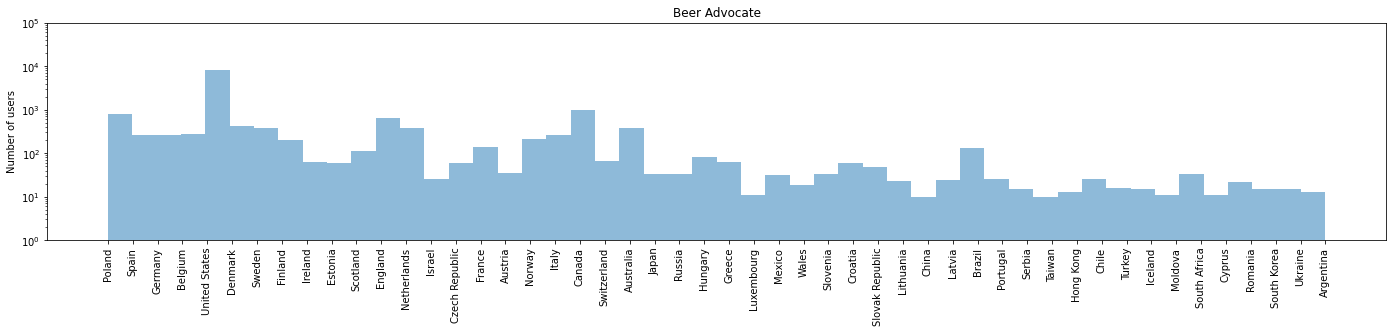

In [14]:
fig, ax = plt.subplots(figsize= (24,4))
ax.hist(filtered_users.country.values, bins =len(users_group_country),log = True, alpha = 0.5)
ax.set_ylim(1, 100000)
ax.set_title('Beer Advocate')
plt.xticks(rotation=90)
plt.ylabel("Number of users")
plt.show()

### 2.4.b Sub-region with less than 50 users

In [15]:
region_threshod = 50
users_group = users.groupby("sub-region").agg('size').sort_values(ascending = False)
tot_regions = len(users_group)
bl_region_threshold = pd.DataFrame(users_group>=region_threshod, columns=['region_treshod'])
filtered_users = pd.merge(users, bl_region_threshold, left_on='sub-region', right_on='sub-region')
filtered_users = filtered_users[filtered_users.region_treshod==True].drop(['region_treshod'], axis=1)
print("Number of users after filtering: {}. \nIt's {:.2f}% of the initial number of users ."
      .format(len(filtered_users),len(filtered_users)/tot_users*100))

Number of users after filtering: 15036. 
It's 21.43% of the initial number of users .


In [16]:
users_group_region = filtered_users.groupby("sub-region").agg('size').sort_values(ascending = False)
print("Number of different countries after filtering: {} .\nIt's {:.2f}% of the number of initial location."
      .format(len(users_group_region), len(users_group_region)/tot_regions*100))
users_group_region.head(8)

Number of different countries after filtering: 9 .
It's 60.00% of the number of initial location.


sub-region
Northern America                   9120
Northern Europe                    2200
Western Europe                     1156
Eastern Europe                     1061
Southern Europe                     726
Australia and New Zealand           389
Latin America and the Caribbean     245
Eastern Asia                         83
dtype: int64

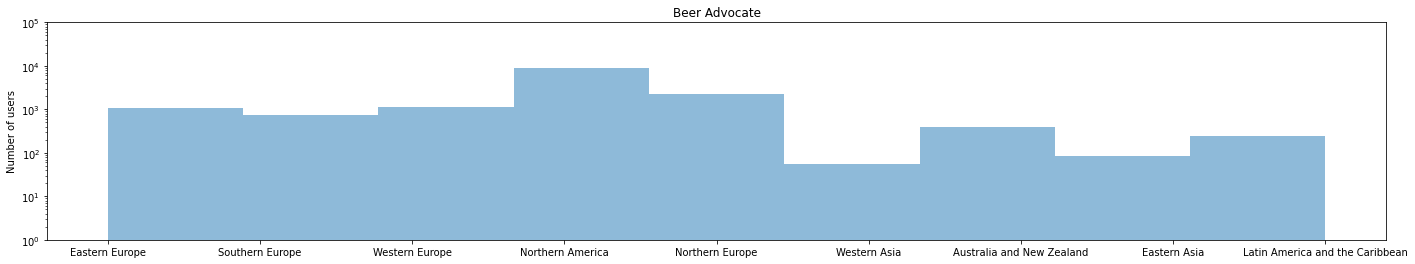

In [17]:
fig, ax = plt.subplots(figsize= (24,4))
ax.hist(filtered_users["sub-region"].values, bins =len(users_group_region),log = True, alpha = 0.5)
ax.set_ylim(1, 100000)
ax.set_title('Beer Advocate')
plt.ylabel("Number of users")
plt.show()

## 3 Analyse data

### 3.1 Find best type by sub-region
#### Problem:
Much of our project is founded on the assumption that a high average rating equates to preference for a particular beer. However, it’s not obvious that this is true. A favorite or most preferred beer could be defined as one that is the most popular / garners the most sales, or it could be one that is known to have great quality but perhaps expensive such that not many can afford it. We can’t exactly be sure if a high rating matches one of these definitions, or perhaps somewhere in between.
#### Solution:
We plan to stick with using high ratings as a proxy for preferences/favorites, but we will ensure that assumptions like these are clearly laid out for the reader.

We merge the ratings dataset with the users dataset to obtain the origin of a rating.

In [18]:
merge_ratings = ratings.merge(filtered_users, on = 'user_name').drop(['user_id_x','user_id_y'], axis=1)
merge_ratings['overall'] = merge_ratings['overall'].astype(int)
merge_ratings.sort_values('overall',ascending = False)[['user_name','overall','style','sub-region']].head(5)

,user_name,overall,style,sub-region
235617,illidurit,20,Imperial Stout,Northern America
275638,Frankieboy,20,India Pale Ale (IPA),Northern America
156140,bulldogops,20,Imperial Stout,Northern America
212828,corkyrory66,20,Amber Ale,Western Europe
156141,bulldogops,20,Imperial Stout,Northern America


We obtain the ranking of the 3 best types of beers by region by taking the average.

In [19]:
top_types_region = []
top_scores_region = []
for region in users_group_region.index: 
    ratings_region = merge_ratings[merge_ratings['sub-region']==region]
    overall_mean_region = ratings_region.groupby('style').agg(overall_mean =('overall', 'mean')).sort_values('overall_mean',ascending = False)
    top_types_region.append(list(overall_mean_region.index))
    top_scores_region.append(list(np.hstack(overall_mean_region.values)))

top = 3
for i in range(len(users_group_region)):
    print('Sub-region: ' + users_group_region.index[i])
    if (len(top_types_region[i])<top):    # if you don't take enough ratings, there may not be enough data to make a top 5
        top = len(top_scores_region[i])
    for j in range(top):
        print('Top {} \t {} with a score of {:.2f}'.format(j+1,top_types_region[i][j],top_scores_region[i][j]))


Sub-region: Northern America
Top 1 	 Abt/Quadrupel with a score of 15.85
Top 2 	 Imperial Stout with a score of 15.37
Top 3 	 Abbey Tripel with a score of 14.97
Sub-region: Northern Europe
Top 1 	 Lambic Style - Fruit with a score of 16.52
Top 2 	 Imperial Stout with a score of 15.36
Top 3 	 Abt/Quadrupel with a score of 15.24
Sub-region: Western Europe
Top 1 	 Mead with a score of 16.50
Top 2 	 Imperial Stout with a score of 15.89
Top 3 	 Lambic Style - Fruit with a score of 15.77
Sub-region: Eastern Europe
Top 1 	 Imperial Stout with a score of 15.30
Top 2 	 American Strong Ale  with a score of 15.15
Top 3 	 Sour Red/Brown with a score of 15.15
Sub-region: Southern Europe
Top 1 	 Lambic Style - Fruit with a score of 17.00
Top 2 	 Abt/Quadrupel with a score of 16.37
Top 3 	 Sour Red/Brown with a score of 16.33
Sub-region: Australia and New Zealand
Top 1 	 Imperial Stout with a score of 16.14
Top 2 	 Abt/Quadrupel with a score of 15.69
Top 3 	 Baltic Porter with a score of 15.57
Sub-re

### 3.2 Make our own sub-region by clustering countries with the same features
Instead of imposing sub-regions, we group countries with similar characteristics using the agglomerative clustering method. \
To visualise our clustering, it is necessary to use the PCA method.

### 4 Representation of the results: Worldmap

We're gone use folium to make a map of the world with the best beer by region.\
https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
